DNN(Deep Neural Network) for regression

objective: Predict the expected electrcitiy consumption

In [358]:
import tensorflow as tf
print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())

/device:GPU:0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [360]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/KnightChaser/ML-challenge/main/EX_challenging_problems/03_power_consumption_prediction/TetuanCityPowerConsumption.csv")             # UPLOADED
print(df)

       Temperature  Humidity  Wind Speed  general diffuse flows  \
0            6.559      73.8       0.083                  0.051   
1            6.414      74.5       0.083                  0.070   
2            6.313      74.5       0.080                  0.062   
3            6.121      75.0       0.083                  0.091   
4            5.921      75.7       0.081                  0.048   
...            ...       ...         ...                    ...   
52411        7.010      72.4       0.080                  0.040   
52412        6.947      72.6       0.082                  0.051   
52413        6.900      72.8       0.086                  0.084   
52414        6.758      73.0       0.080                  0.066   
52415        6.580      74.1       0.081                  0.062   

       diffuse flows  Zone 1 Power Consumption  
0              0.119               34055.69620  
1              0.085               29814.68354  
2              0.100               29128.10127  

In [361]:
df.tail()

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption
52411,7.010,72.4,0.080,0.040,0.096,31160.45627
52412,6.947,72.6,0.082,0.051,0.093,30430.41825
52413,6.900,72.8,0.086,0.084,0.074,29590.87452
52414,6.758,73.0,0.080,0.066,0.089,28958.17490
52415,6.580,74.1,0.081,0.062,0.111,28349.80989


In [362]:
df.isna().sum()         # Are there N/As in the given dataset?

Temperature                 0
Humidity                    0
Wind Speed                  0
general diffuse flows       0
diffuse flows               0
Zone 1 Power Consumption    0
dtype: int64

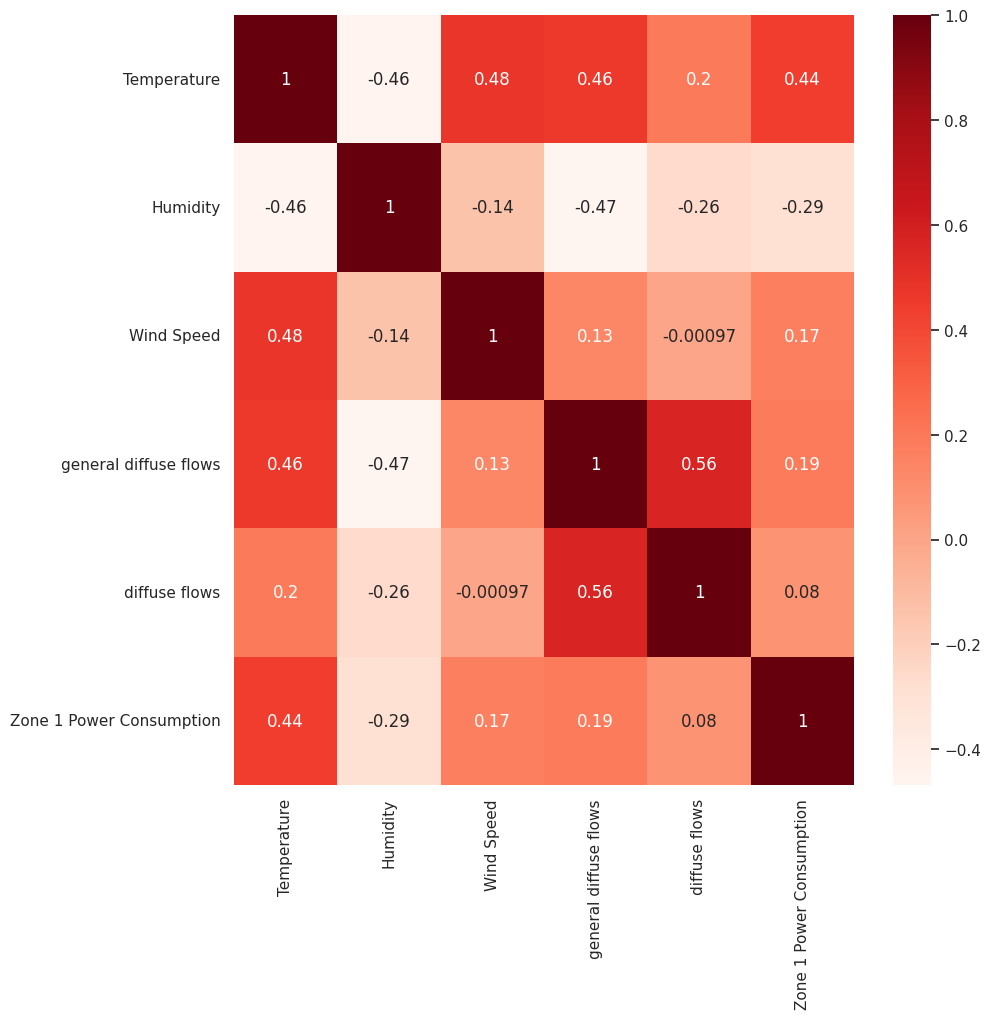

In [363]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation = df.corr()

# heatmap to express correlation
plt.figure(figsize = (10,10))
sns.set(font_scale = 1)
sns.heatmap(correlation, annot = True, cbar = True, cmap="Reds")        # Today my mood is red, anyway.
plt.show()

In [364]:
train_dataset = df.sample(frac = 0.8, random_state = 0xCAFE)
test_dataset  = df.drop(train_dataset.index)

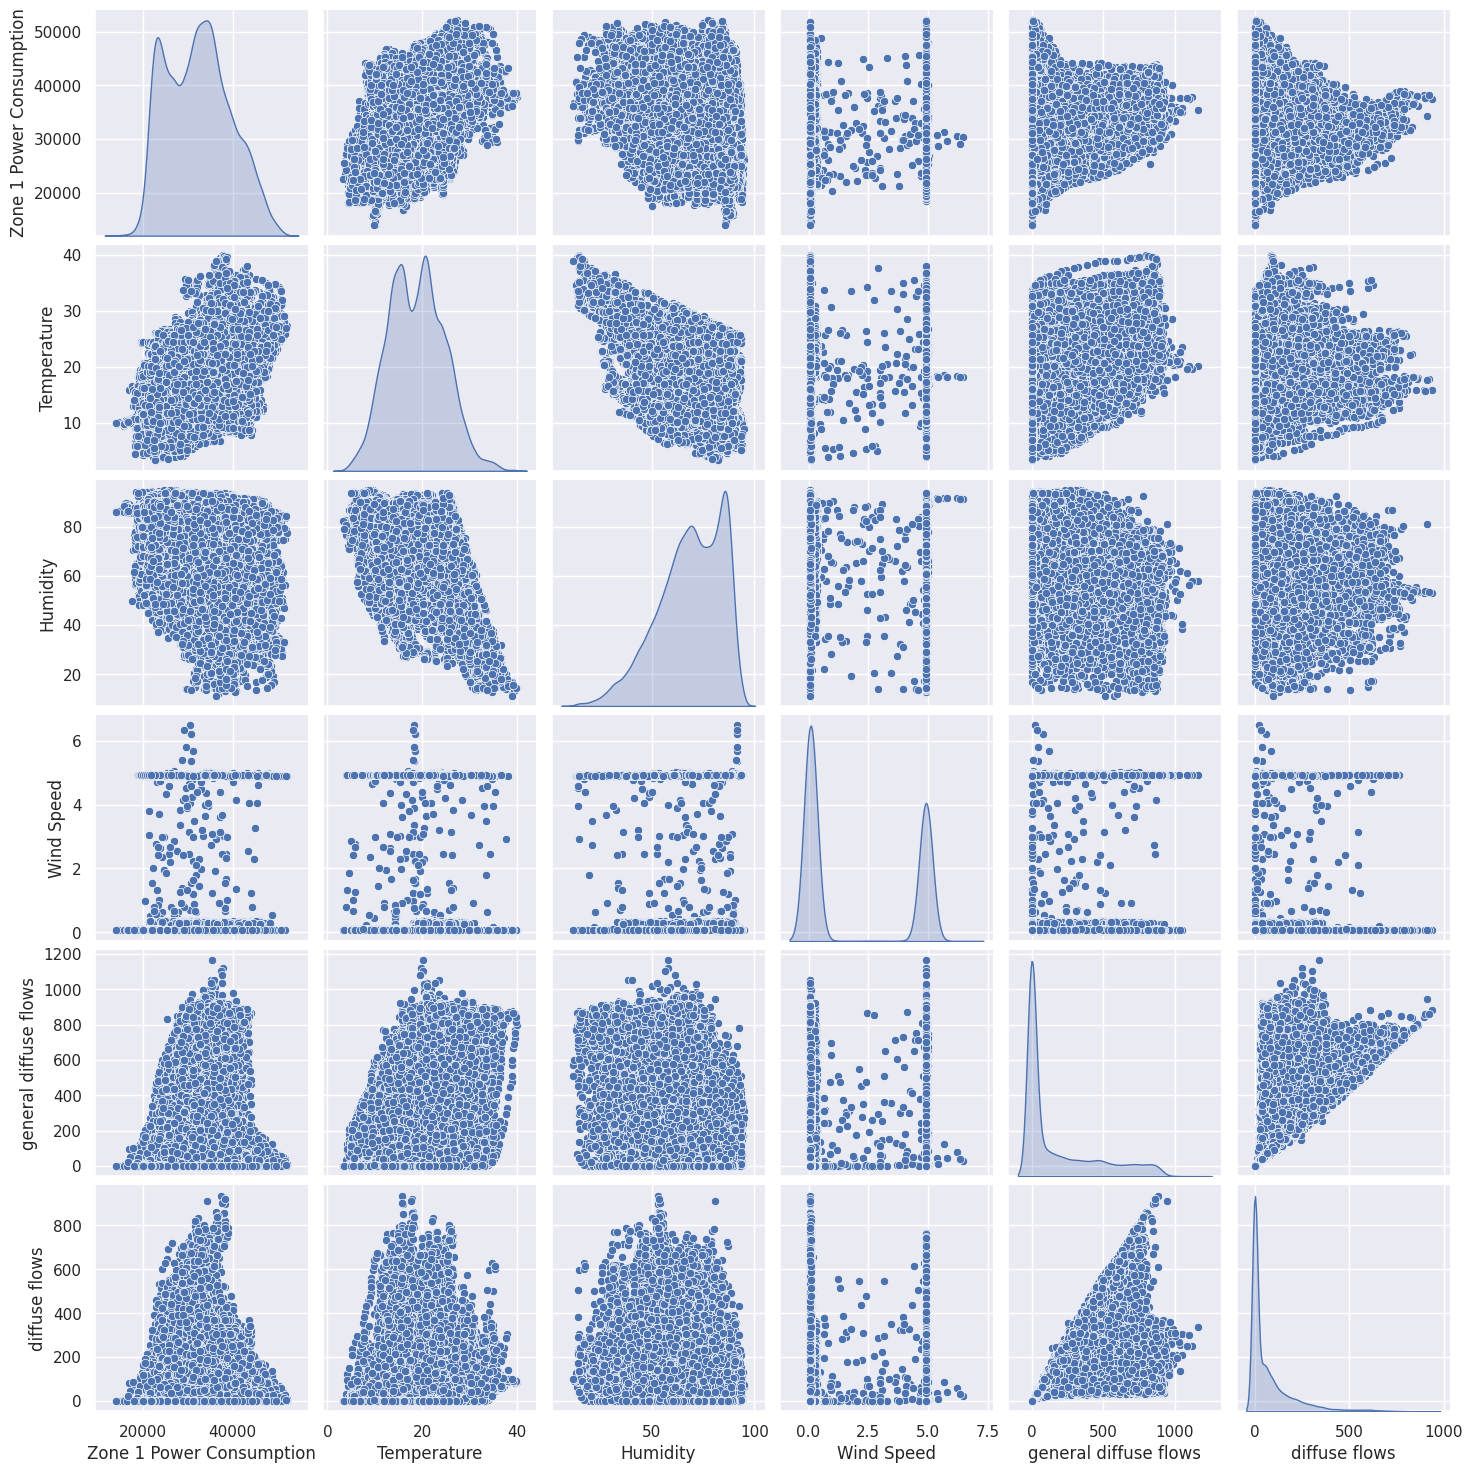

In [365]:
sns.pairplot(train_dataset[["Zone 1 Power Consumption", "Temperature", "Humidity", "Wind Speed", "general diffuse flows", "diffuse flows"]], diag_kind="kde")

In [366]:
train_dataset.describe()

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption
count,41933.000000,41933.000000,41933.000000,41933.000000,41933.000000,41933.000000
mean,18.787461,68.313306,1.961706,182.970287,74.823584,32305.005655
std,5.820681,15.555452,2.349552,264.677198,123.909821,7124.708402
min,3.247000,11.340000,0.050000,0.004000,0.011000,13895.696200
25%,14.390000,58.340000,0.078000,0.062000,0.122000,26251.711520
50%,18.740000,69.890000,0.086000,4.832000,4.324000,32247.457630
75%,22.860000,81.500000,4.915000,320.800000,100.900000,37266.885250
max,40.010000,94.800000,6.483000,1163.000000,936.000000,52204.395120


In [367]:
print(train_dataset.shape)
print(test_dataset.shape)

(41933, 6)
(10483, 6)


In [368]:
# The prdiction objective of the current model
train_target = train_dataset.pop("Zone 1 Power Consumption")
test_target  = test_dataset.pop("Zone 1 Power Consumption")

In [369]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

ss = MinMaxScaler()

ss.fit(train_dataset)
train_scaled = ss.transform(train_dataset)
test_scaled  = ss.transform(test_dataset)

In [370]:
print(train_scaled.shape)
print(train_target.shape)

(41933, 5)
(41933,)


In [396]:
from tensorflow import keras

def create_DNN_model(additional_layers = None):

    model = keras.Sequential()

    if additional_layers:
        for more_model in additional_layers:
            model.add(more_model)

    model.add(keras.layers.Dense(units = 1))

    return model

In [408]:
model = create_DNN_model([keras.layers.Dense(units = 1024, activation = "relu", input_shape = (5, )),
                          keras.layers.Dense(units = 512, activation = "relu"),
                          keras.layers.Dropout(0.3),
                          keras.layers.Dense(units = 128, activation = "relu"),
                          keras.layers.Dense(units = 64, activation = "relu"),
                          keras.layers.Dense(units = 32, activation = "relu"),
                          keras.layers.Dense(units = 16, activation = "relu"),
                         ])
model.summary()

Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_211 (Dense)           (None, 1024)              6144      
                                                                 
 dense_212 (Dense)           (None, 512)               524800    
                                                                 
 dropout_29 (Dropout)        (None, 512)               0         
                                                                 
 dense_213 (Dense)           (None, 128)               65664     
                                                                 
 dense_214 (Dense)           (None, 64)                8256      
                                                                 
 dense_215 (Dense)           (None, 32)                2080      
                                                                 
 dense_216 (Dense)           (None, 16)              

In [410]:
from tensorflow._api.v2.config import optimizer
model.compile(loss = "mse",                         # <-- REGRESSION
              metrics = "mae",
              optimizer = "adam")

In [411]:
from sklearn.utils import validation

early_stopping_checkpoint = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True, mode = "auto")

history = model.fit(train_scaled, train_target,
                    epochs = 200,
                    steps_per_epoch = 1000,
                    validation_data = (test_scaled, test_target),
                    callbacks = [early_stopping_checkpoint])

Epoch 1/200
1000/1000 [==============================] - 9s 7ms/step - loss: 107358584.0000 - mae: 7178.8467 - val_loss: 41993264.0000 - val_mae: 5374.5312
Epoch 2/200
1000/1000 [==============================] - 7s 7ms/step - loss: 42612764.0000 - mae: 5312.0078 - val_loss: 39907684.0000 - val_mae: 5122.7490
Epoch 3/200
1000/1000 [==============================] - 6s 6ms/step - loss: 42184524.0000 - mae: 5275.8008 - val_loss: 40030648.0000 - val_mae: 5187.2349
Epoch 4/200
1000/1000 [==============================] - 6s 6ms/step - loss: 42172016.0000 - mae: 5253.6938 - val_loss: 42054012.0000 - val_mae: 5352.5703
Epoch 5/200
1000/1000 [==============================] - 5s 5ms/step - loss: 42152104.0000 - mae: 5237.2534 - val_loss: 38938968.0000 - val_mae: 5062.0156
Epoch 6/200
1000/1000 [==============================] - 4s 4ms/step - loss: 42110432.0000 - mae: 5235.9888 - val_loss: 39072528.0000 - val_mae: 5042.9961
Epoch 7/200
1000/1000 [==============================] - 6s 6ms/step 

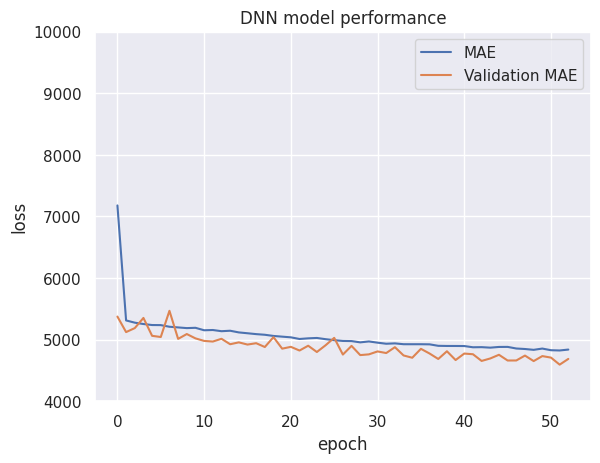

In [412]:
import matplotlib.pyplot as plt

plt.title("DNN model performance")

plt.plot(history.history["mae"], label = "MAE")
plt.plot(history.history["val_mae"], label = "Validation MAE")

plt.ylim([4000, 10000])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

plt.show()

In [413]:
model.evaluate(test_scaled, test_target)

328/328 [==============================] - 1s 4ms/step - loss: 35073348.0000 - mae: 4654.5015


[35073348.0, 4654.50146484375]

328/328 [==============================] - 1s 2ms/step


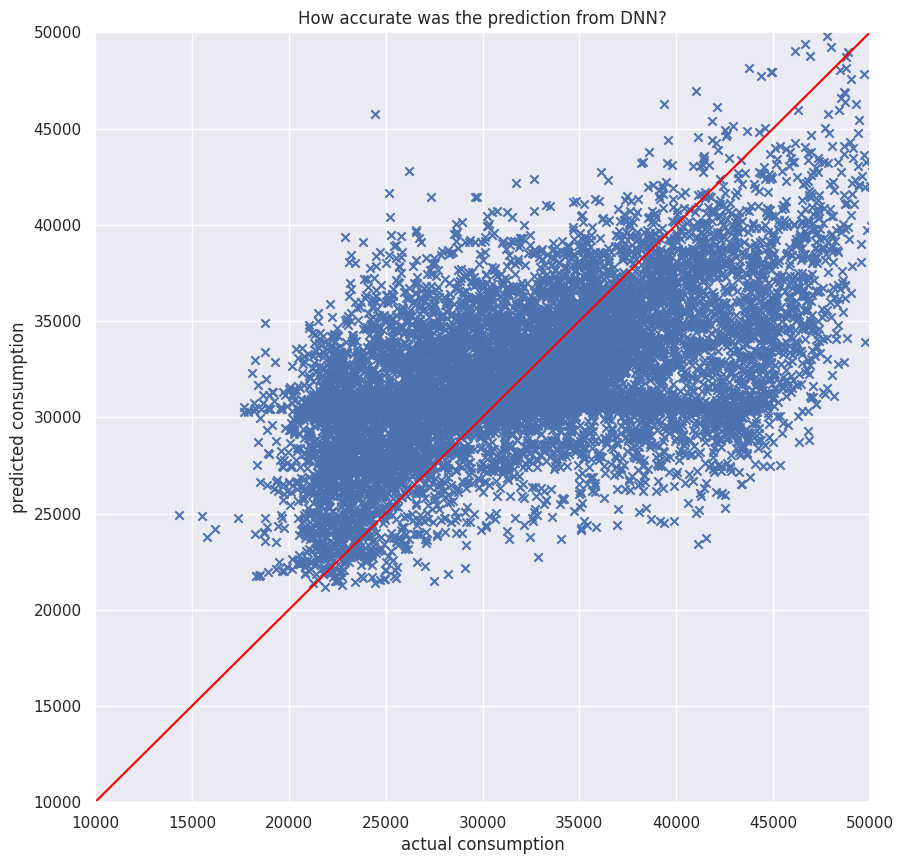

In [414]:
# Prediction Visualization
prediction = model.predict(test_scaled)

plt.figure(figsize = (10, 10))


plt.scatter(test_target, prediction, marker = "x")

plt.title("How accurate was the prediction from DNN?")
plt.xlabel("actual consumption")
plt.ylabel("predicted consumption")

axis_range = [10000, 50000]
plt.plot(axis_range, axis_range, linestyle = "solid", color = "red")
plt.xlim(axis_range)
plt.ylim(axis_range)

plt.show()

# If the scattered plots more nearly approximates to the red diagonal line which represents the exact
# ratio of 1:1 for prediction:real, the model performed better.